#### Задача классификации

По исходным признакам спрогнозировать целевую переменную, а именно предсказать вес человека — дефицитный, нормальный, избыточный и т. д. Целевая метрика — точность (accuracy).

#### Импорт библиотек и настройки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import xgboost
from xgboost import XGBClassifier
import optuna
from pickle import dump

In [2]:
plt.style.use('dark_background')

In [3]:
tableau_palette = [*colors.TABLEAU_COLORS.values()]

#### Описание и загрузка данных

Расшифровка полей в датасете:

- Gender — пол
- Age — возраст
- Height — рост
- Weight — вес
- BMI (Body Mass Index) — индекс массы тела
- FHWO (Family History With Overweight) — наличие родственников с лишним весом
- FAVC (Frequent Consumption of High Caloric Food) — употребление калорийной еды
- FCVC (Frequency of Consumption of Vegetables) — частота употребления овощей
- NCP (Number of Main Meals) — количество основных приемов еды
- CAEC (Consumption of Food Between Meals) — частота перекусов
- CH20 (Consumption of Water Daily) — потребление воды
- SCC (Calories Consumption Monitoring) — мониторинг калорий
- FAF (Physical Activity Frequency) — частота физических упражнений
- TUE (Time Using Technology Devices) — время использования гаджетов
- CALC (Consumption of Alcohol) — употребление алкоголя
- Transport (Transportation Used) — основной вид транспорта
- Status — диагноз (целевая переменная)

In [4]:
train_df = pd.read_csv('data/train.csv')

In [5]:
train_df.head()

,Gender,Age,Height,Weight,BMI,FHWO,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transport,Status
0,Мужчина,24.443011,1.699998,81.669950,28.259565,Да,Да,2.000000,2.983297,Редко,2.763573,Нет,0.000000,0.976473,Редко,Общественный,Избыток 2 ст
1,Женщина,18.000000,1.560000,57.000000,23.422091,Да,Да,2.000000,3.000000,Часто,2.000000,Нет,1.000000,1.000000,Никогда,Автомобиль,Норма
2,Женщина,18.000000,1.711460,50.165754,17.126706,Да,Да,1.880534,1.411685,Редко,1.910378,Нет,0.866045,1.673584,Никогда,Общественный,Дефицит
3,Женщина,20.952737,1.710730,131.274851,44.855798,Да,Да,3.000000,3.000000,Редко,1.674061,Нет,1.467863,0.780199,Редко,Общественный,Ожирение 3 ст
4,Мужчина,31.641081,1.914186,93.798055,25.599151,Да,Да,2.679664,1.971472,Редко,1.979848,Нет,1.967973,0.931721,Редко,Общественный,Избыток 2 ст


In [6]:
pd.DataFrame({'count': train_df.count(), 'isna': train_df.isna().sum(), 'nunique': train_df.nunique(), 'dtypes': train_df.dtypes})

,count,isna,nunique,dtypes
Gender,20758,0,2,object
Age,20758,0,1703,float64
Height,20758,0,1833,float64
Weight,20758,0,1979,float64
BMI,20758,0,12605,float64
FHWO,20758,0,2,object
FAVC,20758,0,2,object
FCVC,20758,0,934,float64
NCP,20758,0,689,float64
CAEC,20758,0,4,object


Помимо целевой переменной в наборе данных есть 16 признаков. Из них 9 — числовые, остальные 7 — категориальные. Пропущенных значений нет ни в одном из признаков.

#### Разведочный анализ

Закодируем и упорядочим целевую переменную, чтобы диагнозы на графиках распологались в логическом порядке — от дефицита веса к ожирению.

In [7]:
train_df.Status.unique().tolist()

['Избыток 2 ст',
 'Норма',
 'Дефицит',
 'Ожирение 3 ст',
 'Ожирение 2 ст',
 'Избыток 1 ст',
 'Ожирение 1 ст']

In [8]:
target_map = {
    'Дефицит': 0,
    'Норма': 1,
    'Избыток 1 ст': 2,
    'Избыток 2 ст': 3,
    'Ожирение 1 ст': 4,
    'Ожирение 2 ст': 5,
    'Ожирение 3 ст': 6,
}

In [9]:
target_order = [*target_map.keys()]

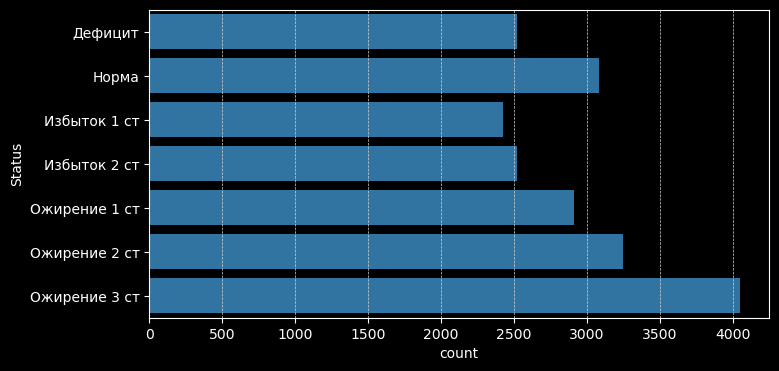

In [10]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=train_df, y='Status', color='tab:blue', order=target_order)
ax.grid(axis='x', color='lightgray', linestyle='dashed', linewidth=0.5)

Самые частые диагнозы — норма и ожирение разной степени. Людей с дефицитом и избытком веса меньше всего.

Для разведочного анализа разделим признаки на числовые и категориальные.

In [11]:
numeric_columns = train_df.select_dtypes(exclude='object').columns

In [12]:
categorical_columns = train_df.drop('Status', axis=1).select_dtypes(include='object').columns

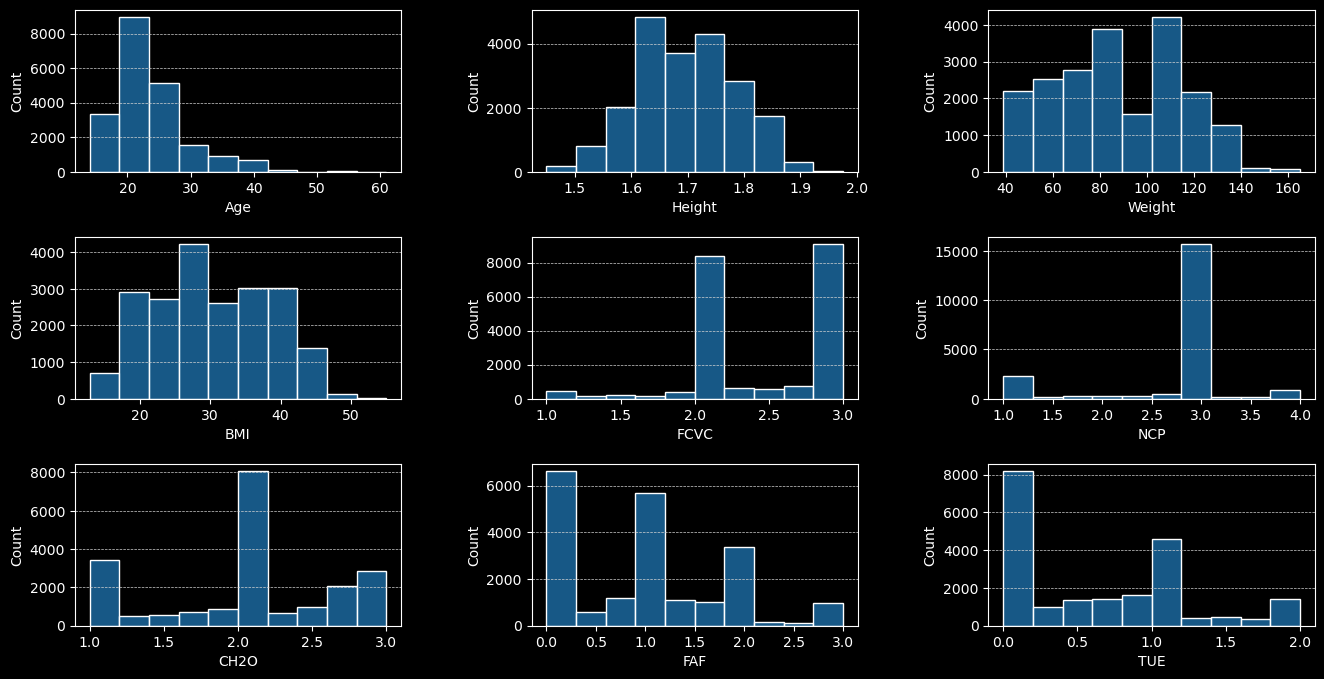

In [13]:
plt.figure(figsize=(16, 8)).subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(numeric_columns):
    ax = sns.histplot(data=train_df, x=column, bins=10, color='tab:blue', ax=plt.subplot(3, 3, i + 1))
    ax.grid(axis='y', color='lightgray', linestyle='dashed', linewidth=0.5)

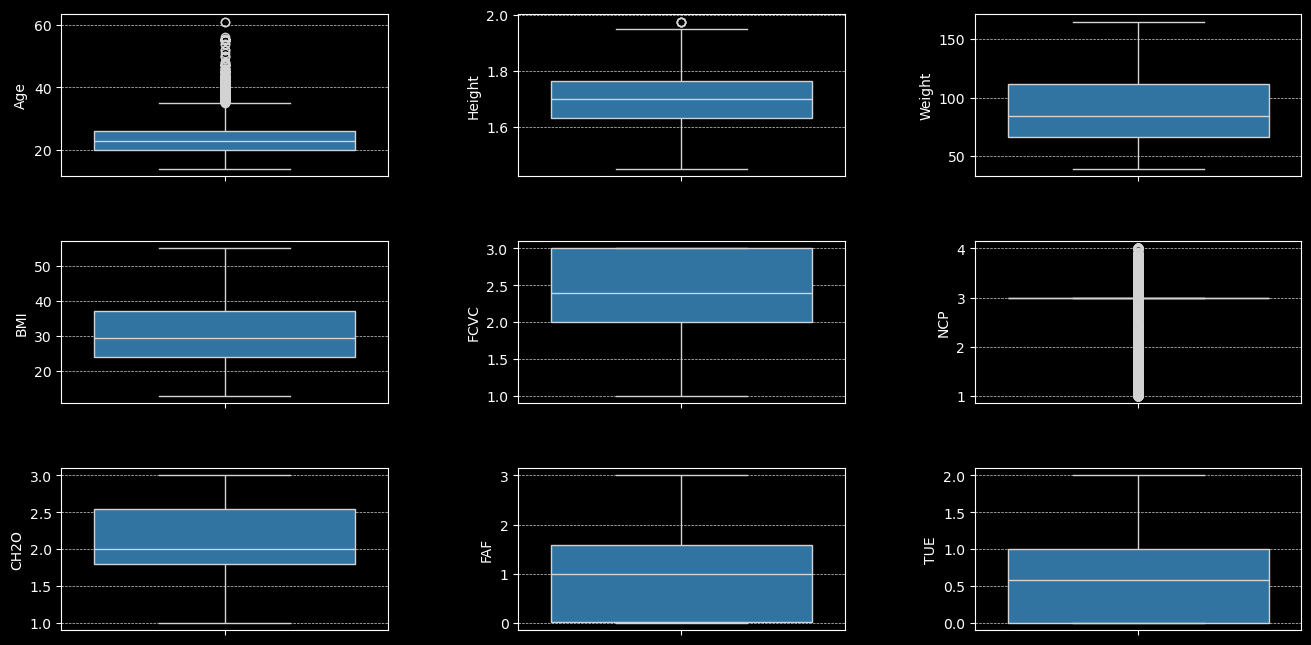

In [14]:
plt.figure(figsize=(16, 8)).subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(numeric_columns):
    ax = sns.boxplot(data=train_df, y=column, color='tab:blue', linecolor='lightgray', ax=plt.subplot(3, 3, i + 1))
    ax.grid(axis='y', color='lightgray', linestyle='dashed', linewidth=0.5)

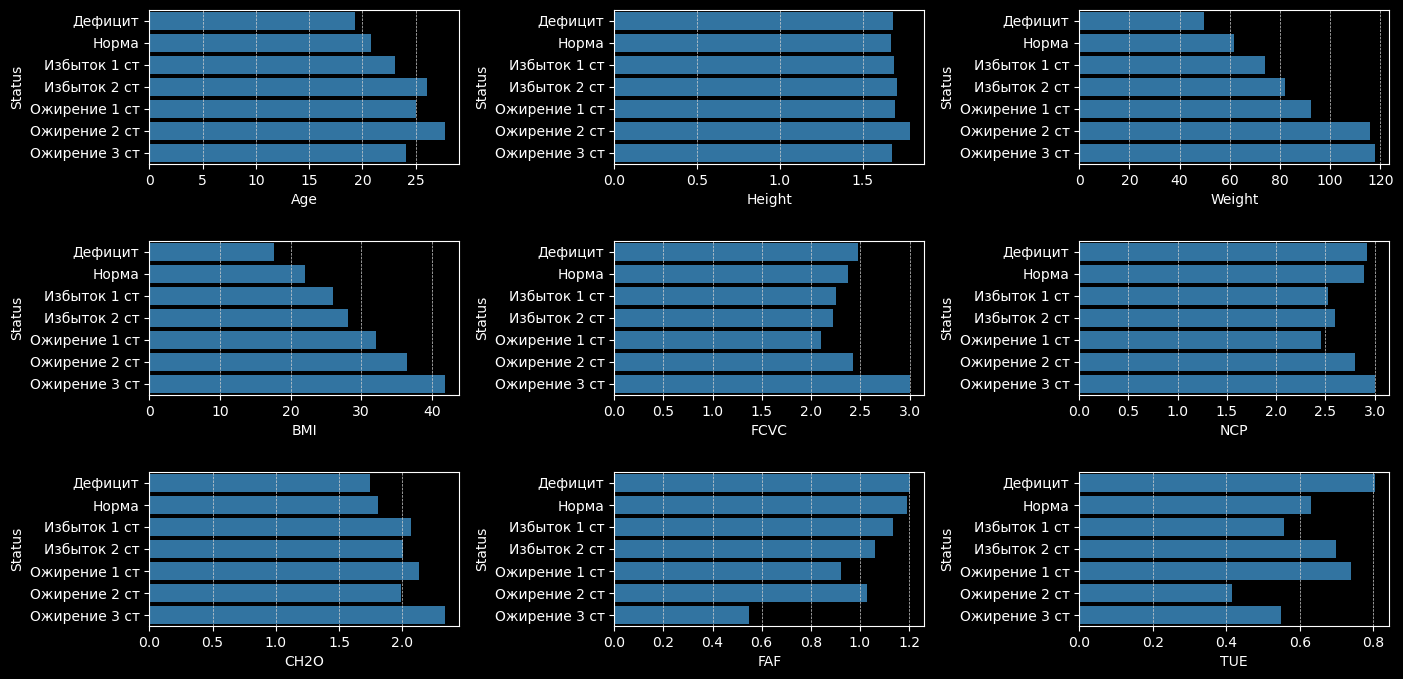

In [15]:
plt.figure(figsize=(16, 8)).subplots_adjust(hspace=0.5, wspace=0.5)
for i, column in enumerate(numeric_columns):
    ax = sns.barplot(data=train_df.groupby('Status')[column].mean(), orient='h', color='tab:blue', order=target_order, ax=plt.subplot(3, 3, i + 1))
    ax.grid(axis='x', color='lightgray', linestyle='dashed', linewidth=0.5)

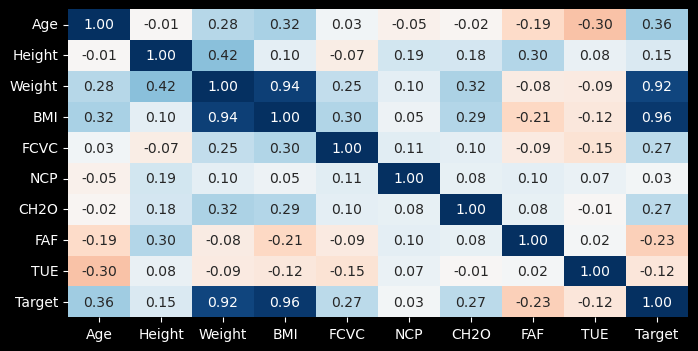

In [16]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=train_df.assign(Target=train_df.Status.map(target_map)).corr(numeric_only=True), annot=True, fmt='.2f', cmap='RdBu', vmin=-1, vmax=1, cbar=False)

Наблюдения по числовым признакам:

- Дефицитный и нормальный вес чаще встречается у молодых (Age).
- Полные люди реже занимаются спортом (FAF).
- У целевой переменной сильная линейная связь с индексом массы тела (BMI) и весом (Weight).

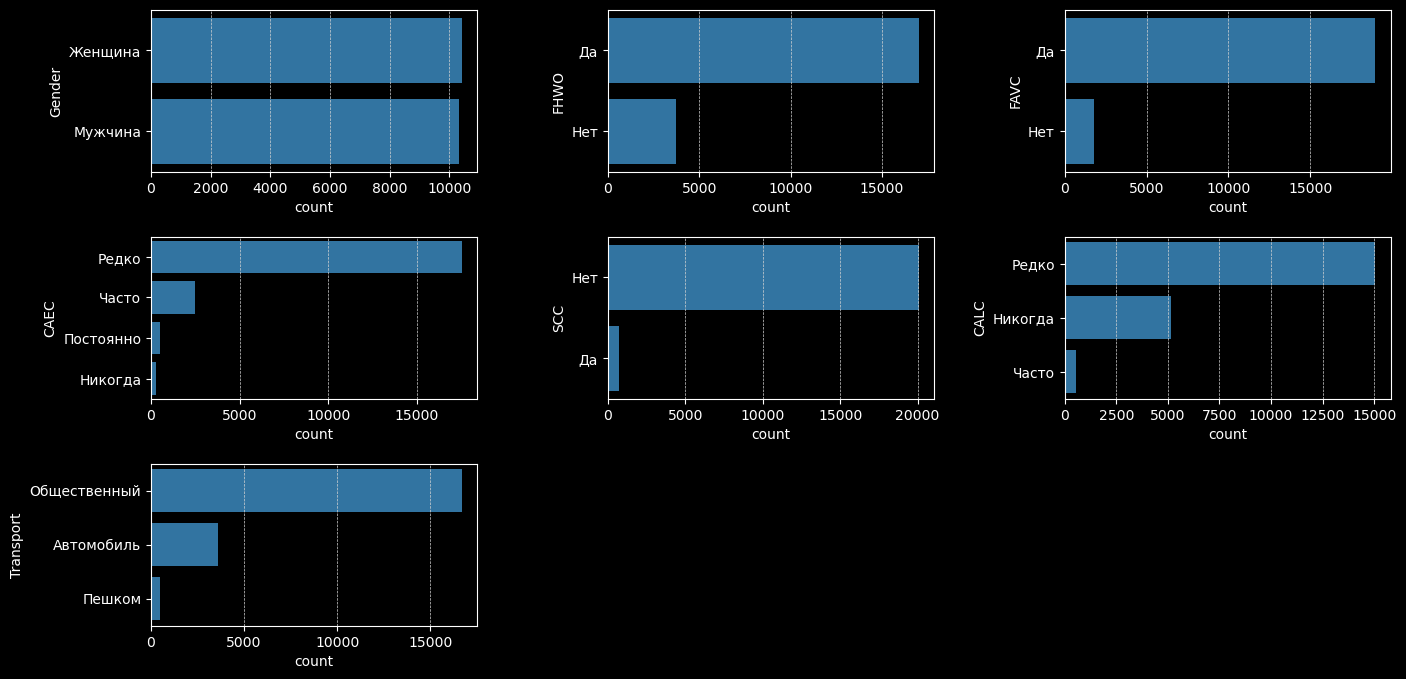

In [17]:
plt.figure(figsize=(16, 8)).subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(categorical_columns):
    ax = sns.barplot(data=train_df[column].value_counts(), orient='h', color='tab:blue', ax=plt.subplot(3, 3, i + 1))
    ax.grid(axis='x', color='lightgray', linestyle='dashed', linewidth=0.5)

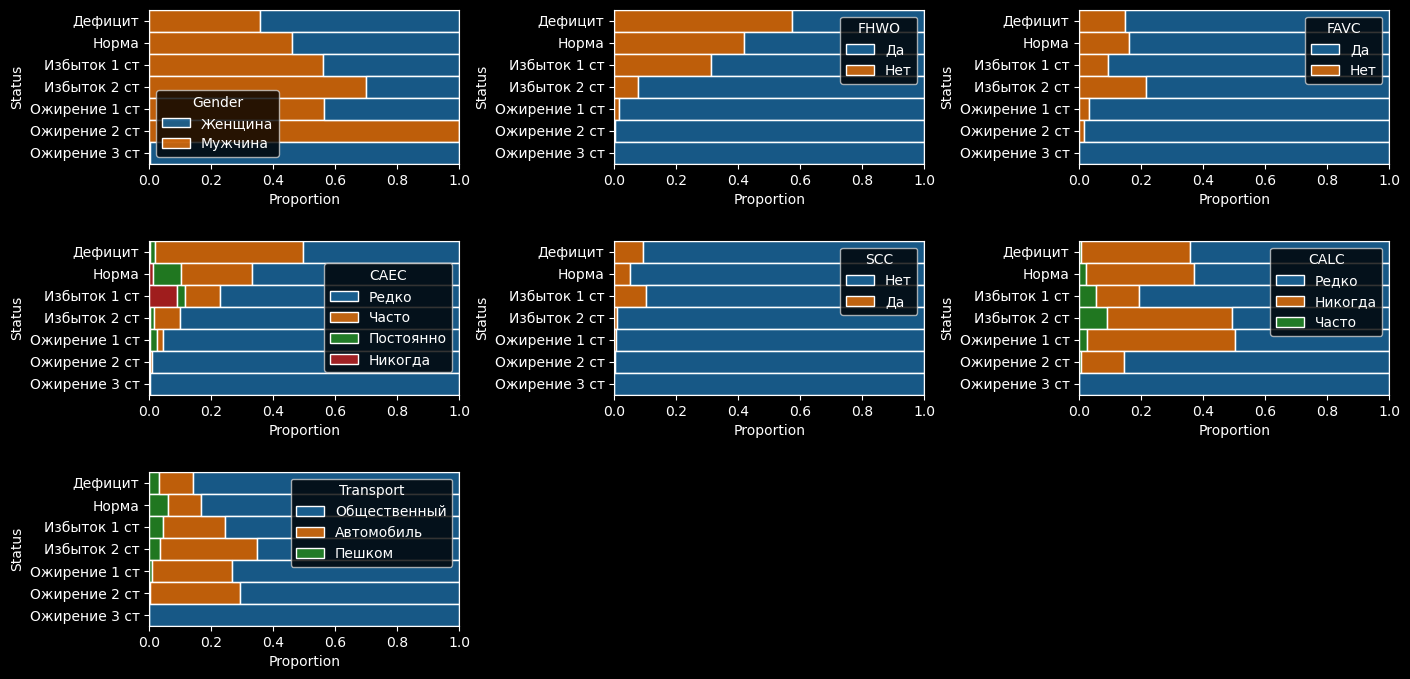

In [18]:
plt.figure(figsize=(16, 8)).subplots_adjust(hspace=0.5, wspace=0.5)
for i, column in enumerate(categorical_columns):
    ax = sns.histplot(data=train_df.sort_values(by='Status', key=lambda x: x.map(target_map)), y='Status', hue=column, hue_order=train_df[column].value_counts().index, multiple='fill', stat='proportion', palette=tableau_palette[:train_df[column].nunique()], ax=plt.subplot(3, 3, i + 1))

Наблюдения по категориальным признакам:

- Ожирение 2 степени встречается у мужчин, 3 степени — у женщин (Gender).
- У полных людей чаще есть родственники с лишним весом (FHWO).
- Полные люди чаще едят калорийную еду (FAVC).
- Полные люди реже перекусывают (CAEC).
- Полные люди реже подсчитывают калории (SCC).
- Полные люди реже передвигаются пешком (Transport).

#### Сплит данных

In [19]:
X = train_df.drop('Status', axis=1)

In [20]:
label_encoder = LabelEncoder()

In [21]:
label_encoder.fit(train_df.Status)

LabelEncoder()

In [22]:
label_encoder.classes_ = pd.Series(target_order)

In [23]:
y = label_encoder.transform(train_df.Status)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#### Обучение модели

Деревья решений — это нелинейные модели, поэтому для кодировки категориальных признаков возьмем Ordinal Encoder, а не One Hot Encoder, который увеличивает размерность датасета.

In [25]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [26]:
column_transformer = ColumnTransformer(
    transformers=[('categorical', ordinal_encoder, categorical_columns)],
    remainder='passthrough',
    force_int_remainder_cols=False,
    verbose_feature_names_out=False,
).set_output(transform='pandas')

In [27]:
column_transformer.fit(X_train)

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('categorical',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 Index(['Gender', 'FHWO', 'FAVC', 'CAEC', 'SCC', 'CALC', 'Transport'], dtype='object'))],
                  verbose_feature_names_out=False)

In [28]:
dtrain = xgboost.DMatrix(column_transformer.transform(X_train), y_train)

In [29]:
def objective(trial):
    params = {
        'eta': trial.suggest_float('eta', 0.05, 0.30, step=0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100, step=1),
        'subsample': trial.suggest_float('subsample', 0.50, 1.00, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.50, 1.00, step=0.05),
        'lambda': trial.suggest_float('lambda', 0.01, 100.00, log=True),
    }
    params['objective'] = 'multi:softmax'
    params['tree_method'] = 'hist'
    params['num_class'] = '7'
    cv = xgboost.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        early_stopping_rounds=50,
        nfold=5,
        stratified=True,
        seed=0,
        metrics='merror',
    )
    score = cv.iloc[len(cv) - 1]['test-merror-mean']
    return score

In [30]:
study = optuna.create_study(study_name='optuna_study', direction='minimize')

[I 2025-02-01 16:07:14,392] A new study created in memory with name: optuna_study


In [31]:
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-02-01 16:07:53,065] Trial 0 finished with value: 0.09574847163281988 and parameters: {'eta': 0.3, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.75, 'colsample_bytree': 0.55, 'lambda': 0.011434349732644943}. Best is trial 0 with value: 0.09574847163281988.
[I 2025-02-01 16:08:33,456] Trial 4 finished with value: 0.09484532867938886 and parameters: {'eta': 0.3, 'max_depth': 7, 'min_child_weight': 37, 'subsample': 0.9, 'colsample_bytree': 0.8500000000000001, 'lambda': 2.03101943106123}. Best is trial 4 with value: 0.09484532867938886.
[I 2025-02-01 16:09:43,517] Trial 3 finished with value: 0.09321929429074209 and parameters: {'eta': 0.2, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.95, 'colsample_bytree': 0.6, 'lambda': 90.75654869089664}. Best is trial 3 with value: 0.09321929429074209.
[I 2025-02-01 16:10:03,990] Trial 1 finished with value: 0.09267730699917207 and parameters: {'eta': 0.05, 'max_depth': 5, 'min_child_weight': 29, 'subsample': 0.75, 'colsample

In [32]:
best_params = study.best_params
best_params['objective'] = 'multi:softmax'
best_params['tree_method'] = 'hist'
best_params['num_class'] = 7
best_params

{'eta': 0.05,
 'max_depth': 5,
 'min_child_weight': 29,
 'subsample': 0.75,
 'colsample_bytree': 1.0,
 'lambda': 0.5012433922190179,
 'objective': 'multi:softmax',
 'tree_method': 'hist',
 'num_class': 7}

In [33]:
cv = xgboost.cv(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    nfold=5,
    stratified=True,
    seed=0,
    metrics='merror',
)

In [34]:
cv.tail()

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
436,0.068951,0.000923,0.093039,0.001603
437,0.068740,0.000858,0.092978,0.001695
438,0.068755,0.000869,0.093039,0.001679
439,0.068605,0.000865,0.092978,0.001607
440,0.068605,0.000851,0.092677,0.001629


In [35]:
best_round = len(cv)
best_round

441

In [36]:
classifier = XGBClassifier(**{
    'n_estimators': best_round,
    'learning_rate': best_params['eta'],
    'max_depth': best_params['max_depth'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_lambda': best_params['lambda'],
    'objective': best_params['objective'],
    'tree_method': best_params['tree_method'],
    'num_class': best_params['num_class'],
})

In [37]:
pipe = Pipeline([
    ('column_transformer', column_transformer),
    ('classifier', classifier),
])

In [38]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Gender', 'FHWO', 'FAVC', 'CAEC', 'SCC', 'CALC', 'Transport'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBClassifier...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=29, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=441, n_jobs=None, num_class=7,
                               num_parallel_tree=None, ...))])

In [39]:
accuracy_score(y_true=y_train, y_pred=pipe.predict(X_train))

0.9307479224376731

In [40]:
accuracy_score(y_true=y_test, y_pred=pipe.predict(X_test))

0.9099229287090559

Точность на тестовом наборе незначительно ниже, чем на тренировочном, значит, модель не переобучена.

In [41]:
feature_importances = pd.DataFrame({
    'feature': classifier.get_booster().get_score(importance_type='gain').keys(),
    'importance': classifier.get_booster().get_score(importance_type='gain').values(),
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [42]:
feature_importances

,feature,importance
0,BMI,61.005203
1,Gender,46.567085
2,Weight,20.324734
3,FAVC,8.272180
4,FCVC,6.932570
5,SCC,5.555905
6,CH2O,5.146892
7,CALC,4.506109
8,Age,3.558411
9,CAEC,3.533206


Признаки BMI, Gender и Weight внесли наибольший вклад в точность модели. Удаление неинформативных признаков или добавление новых не повышает точность модели.

#### Анализ результатов

In [43]:
y_cv = cross_val_predict(estimator=pipe, X=X, y=y, cv=5, n_jobs=-1)

In [44]:
print(classification_report(y_true=y, y_pred=y_cv, target_names=target_order, digits=2))

               precision    recall  f1-score   support

      Дефицит       0.93      0.94      0.93      2523
        Норма       0.88      0.89      0.88      3082
 Избыток 1 ст       0.82      0.77      0.80      2427
 Избыток 2 ст       0.81      0.83      0.82      2522
Ожирение 1 ст       0.90      0.89      0.89      2910
Ожирение 2 ст       0.97      0.97      0.97      3248
Ожирение 3 ст       1.00      1.00      1.00      4046

     accuracy                           0.91     20758
    macro avg       0.90      0.90      0.90     20758
 weighted avg       0.91      0.91      0.91     20758



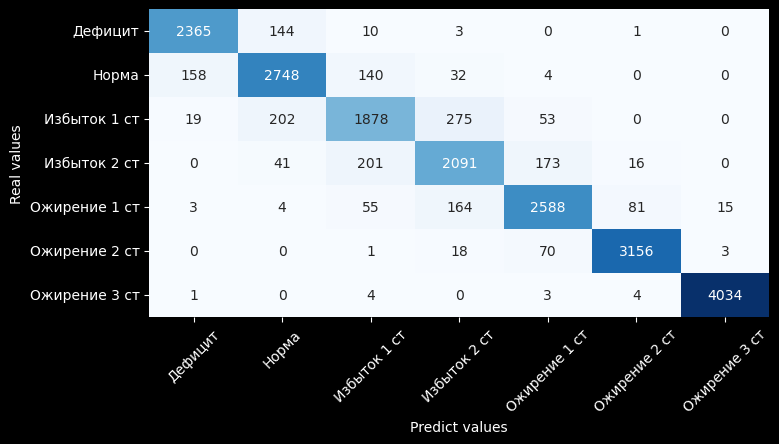

In [45]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=confusion_matrix(y_true=y, y_pred=y_cv), xticklabels=target_order, yticklabels=target_order, annot=True, fmt='g', cmap='Blues', cbar=False)
ax.set_ylabel('Real values')
ax.set_xlabel('Predict values')
_ = ax.tick_params(axis='x', labelrotation=45)

Самые низкие точность (precision) и полнота (recall) у людей с избыточным весом 1 и 2 степени — в районе 80%. Модель часто путает местами эти два диагноза.

Отчасти проблема в том, что самый информативный признак (BMI) несильно отличается у людей с избыточным весом 1 и 2 степени. Возможно, стоит создать какой-то новый признак, который бы хорошо разделял эти диагнозы.

Кроме прочего, диагнозы с избыточным весом 1 и 2 степени встречаются реже других. Возможно, стоит добавить больше обучающих образцов именно для этих категорий.

Сохраним результаты кросс-валидации и модель.

In [46]:
cv_df = pd.DataFrame({'y_true': y, 'y_pred': y_cv})

In [47]:
cv_df.head()

,y_true,y_pred
0,3,3
1,1,1
2,0,0
3,6,6
4,3,3


In [48]:
cv_df.to_csv('data/preds.csv', index=False)

In [49]:
pipe.fit(X, y)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['Gender', 'FHWO', 'FAVC', 'CAEC', 'SCC', 'CALC', 'Transport'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBClassifier...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=29, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=441, n_jobs=None, num_class=7,
                               num_parallel_tree=None, ...))])

In [50]:
with open('data/model.pkl', 'wb') as f:
    dump(pipe, f, protocol=5)